✅ Starting Model Training...
📢 Training the Student Model using Knowledge Distillation...
📌 Epoch 1: Loss = 0.6842, Accuracy = 32.06%
📌 Epoch 2: Loss = 0.5984, Accuracy = 48.25%
📌 Epoch 3: Loss = 0.5357, Accuracy = 56.98%
📌 Epoch 4: Loss = 0.5072, Accuracy = 60.33%
📌 Epoch 5: Loss = 0.4933, Accuracy = 62.46%
📌 Epoch 6: Loss = 0.4708, Accuracy = 65.60%
📌 Epoch 7: Loss = 0.4535, Accuracy = 67.71%
📌 Epoch 8: Loss = 0.4366, Accuracy = 69.98%
📌 Epoch 9: Loss = 0.4250, Accuracy = 70.73%
📌 Epoch 10: Loss = 0.4034, Accuracy = 73.46%
📌 Epoch 11: Loss = 0.3940, Accuracy = 74.46%
📌 Epoch 12: Loss = 0.3862, Accuracy = 75.85%
📌 Epoch 13: Loss = 0.3806, Accuracy = 76.38%
📌 Epoch 14: Loss = 0.3716, Accuracy = 77.54%
📌 Epoch 15: Loss = 0.3583, Accuracy = 78.75%
📌 Epoch 16: Loss = 0.3578, Accuracy = 78.79%
📌 Epoch 17: Loss = 0.3540, Accuracy = 79.73%
📌 Epoch 18: Loss = 0.3414, Accuracy = 81.23%
📌 Epoch 19: Loss = 0.3388, Accuracy = 81.52%
📌 Epoch 20: Loss = 0.3363, Accuracy = 81.79%
📌 Epoch 21: Loss = 

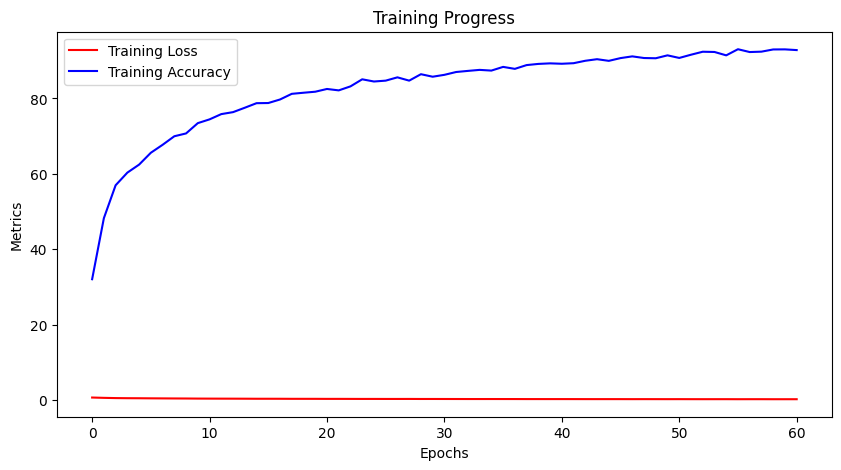


📊 Model Evaluation Results:

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 73.00% |
| Precision | 74.32% |
|   Recall  | 73.00% |
|  F1 Score | 73.27% |
+-----------+--------+


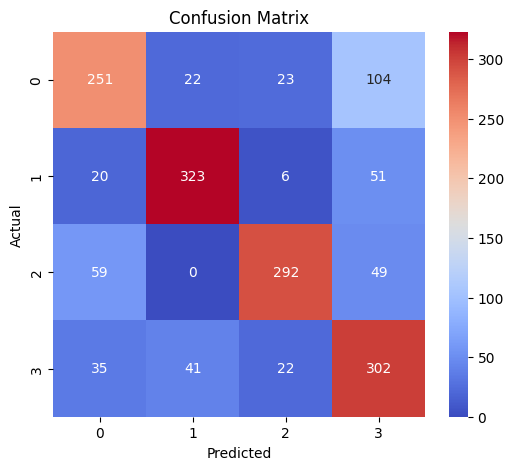

(73.0, 74.31521739150882, 73.0, 73.26903651093622)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from vit_pytorch import SimpleViT
from prettytable import PrettyTable
from colored import fg, attr

# Suppress CUDA errors if unavailable
torch.backends.cudnn.enabled = False

# Define colors for beautiful printouts
success = fg('green') + attr('bold')
warning = fg('yellow') + attr('bold')
error = fg('red') + attr('bold')
info = fg('blue') + attr('bold')
reset = attr('reset')

print(success + "✅ Starting Model Training..." + reset)

# Define the Teacher Model (Lightweight Vision Transformer)
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.vit = SimpleViT(
            image_size=32,
            patch_size=4,
            num_classes=4,
            dim=128,
            depth=2,
            heads=4,
            mlp_dim=256
        )
    
    def forward(self, x):
        return self.vit(x)

# Define the Student Model (Sparse CNN)
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define Dataset & DataLoader
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize Models
device = torch.device("cpu")
teacher_model = TeacherModel().to(device)
student_model = StudentModel().to(device)

# Define Loss, Optimizer, and KD Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

def kd_loss(student_outputs, teacher_outputs, labels, alpha=0.5, temperature=3.0):
    soft_targets = F.softmax(teacher_outputs / temperature, dim=1)
    soft_loss = F.kl_div(F.log_softmax(student_outputs / temperature, dim=1), soft_targets, reduction='batchmean')
    hard_loss = F.cross_entropy(student_outputs, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Train Student Model
def train_student(student, teacher, train_loader, criterion, optimizer, patience=5):
    teacher.eval()
    student.train()

    train_losses, train_accuracies = [], []
    best_accuracy = 0
    patience_counter = 0

    print(info + "📢 Training the Student Model using Knowledge Distillation..." + reset)

    for epoch in range(100):  
        running_loss = 0.0
        correct, total = 0, 0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = teacher(images)
            
            student_outputs = student(images)
            loss = kd_loss(student_outputs, teacher_outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds) * 100
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(accuracy)

        print(success + f"📌 Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Accuracy = {accuracy:.2f}%" + reset)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(student.state_dict(), "student_model.pth")
            patience_counter = 0  
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(error + "🛑 Early stopping triggered! Training complete." + reset)
            break

    print(success + "✅ Best Student Model Saved!" + reset)

    # Plot Accuracy & Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss", color="red")
    plt.plot(train_accuracies, label="Training Accuracy", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Training Progress")
    plt.legend()
    plt.show()

# Train the Student Model
train_student(student_model, teacher_model, train_loader, criterion, optimizer)

# Evaluate the Student Model
def evaluate_student(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='weighted') * 100
    recall = recall_score(all_labels, all_preds, average='weighted') * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100

    # Display Results in Table
    table = PrettyTable(["Metric", "Score"])
    table.add_row(["Accuracy", f"{accuracy:.2f}%"])
    table.add_row(["Precision", f"{precision:.2f}%"])
    table.add_row(["Recall", f"{recall:.2f}%"])
    table.add_row(["F1 Score", f"{f1:.2f}%"])
    
    print(success + "\n📊 Model Evaluation Results:\n" + reset)
    print(table)

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, precision, recall, f1

# Run evaluation
evaluate_student(student_model, test_loader)
